# Modélisation des méandres des rivières Modèle 2 

### Importation des librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.interpolate import make_interp_spline
from scipy.spatial import distance

### Fonctions

In [2]:
def creation_du_canal(W,D,Sl,deltas,pad,n_bends):
    """Génère un canal avec un peu de bruit
  W - largeur du canal
  D - profondeur du canal
  Sl - pente du canal
  deltas - distance entre les noeuds par rapport au centre du canal
  pad - nombre de noeuds le long du centre du canal
  n_bends -nombre de courbures générer"""
    bruit = n_bends*10*W/2.0 
    pad1 = int(pad/10.0)
    if pad1<5:
        pad1 = 5
    x = np.linspace(0, bruit+(pad+pad1)*deltas, int(bruit/deltas+pad+pad1)+1)
    y = 10.0 * (2*np.random.random_sample(int(bruit/deltas)+1,)-1)
    y = np.hstack((np.zeros((pad1),),y,np.zeros((pad),))) 
    return x,y

In [3]:
def calcul_courbure(x,y):
    """fonction qui calcule la courbure locale du canal en fonction des coordonnées
    s - la distance entre le début du canal jusqu'à la courbe
    """
    dx = np.gradient(x)
    dy = np.gradient(y)      
    ddx = np.gradient(dx)
    ddy = np.gradient(dy) 
    curvature = (dx*ddy-dy*ddx)/((dx**2+dy**2)**1.5)
    return curvature

In [4]:
def calcul_derivees(x,y):
    """fonction qui calcule les dérivées"""
    dx = np.gradient(x)
    dy = np.gradient(y)      
    ds = np.sqrt(dx**2+dy**2)
    s = np.hstack((0,np.cumsum(ds[1:])))
    return dx, dy, ds, s

In [5]:
def calcul_R0(kl, curv,W):
    """fonction qui calcule le taux de migration nominale"""
    curv = W*curv 
    R0 = kl*curv 
    return R0

In [6]:
def calcul_taux_migration(pad,ns,ds,alpha,omega,gamma,R0, beta, petit_gamma):
    """ calcul le taux de migration ajusté R1
    R0 - taux de migration nominal"""
    R1 = np.zeros_like(R0)
    pad1 = int(pad / 10.0)
    if pad1 < 5:
        pad1 = 5
    
    for i in range(pad1, ns - pad):
        si2 = np.hstack(([0], np.cumsum(ds[i-1:i-ns:-1]))) 
        G = np.exp(-alpha * si2)*np.cos(beta*si2 - petit_gamma)
        len_G = len(G)
        if len(R0[i::-1]) < len_G:
            len_G = len(R0[i::-1])
            G = G[:len_G]
        
        R1[i] = omega * R0[i] + gamma * np.sum(R0[i::-1][:len_G] * G) / np.sum(G)
        
    return R1, pad1

In [7]:
def migrate_one_step(x,y,W,kl,dt,k,Cf,D,pad,pad1,omega,gamma,R0,R1, ns, curv,dx,dy,ds,s, alpha):
    '''Cacule la migration step par step
    '''

    sinuosity = s[-1]/(x[-1]-x[0])
    R1 = sinuosity**(-2/3.0)*R1
    dy_ds = dy[pad1:ns-pad+1]/ds[pad1:ns-pad+1]
    dx_ds = dx[pad1:ns-pad+1]/ds[pad1:ns-pad+1]
    x[pad1:ns-pad+1] = x[pad1:ns-pad+1] + R1[pad1:ns-pad+1]*dy_ds*dt  
    y[pad1:ns-pad+1] = y[pad1:ns-pad+1] - R1[pad1:ns-pad+1]*dx_ds*dt 
    return x,y

In [8]:
def kieme_diag_indices(a,k):
    """fonction servant à trouver la k-ième diagonal d'un tableau"
    [from https://stackoverflow.com/questions/10925671/numpy-k-th-diagonal-indices]"""
    rows, cols = np.diag_indices_from(a)
    if k<0:
        return rows[:k], cols[-k:]
    elif k>0:
        return rows[k:], cols[:-k]
    else:
        return rows, cols

In [9]:
def find_cutoffs(x,y,crdist,deltas):
    """fonction permettant de trouver les points de cutoff"""
    diag_blank_width = int((crdist+20*deltas)/deltas)
    dist = distance.cdist(np.array([x,y]).T,np.array([x,y]).T)
    dist[dist>crdist] = np.NaN 
    for k in range(-diag_blank_width,diag_blank_width+1):
        rows, cols = kieme_diag_indices(dist,k)
        dist[rows,cols] = np.NaN
    i1, i2 = np.where(~np.isnan(dist))
    ind1 = i1[np.where(i1<i2)[0]]
    ind2 = i2[np.where(i1<i2)[0]] 
    return ind1, ind2 

In [10]:
def cut_off_cutoffs(x, y, s, crdist, deltas):
    """La fonction qui sera utilisée pour enlever les bras-morts (oxbows) aussi appelés ici les cutoffs"""
    xc, yc = [], []
    ind1, ind2 = find_cutoffs(x,y,crdist,deltas) 
    while len(ind1)>0:
        xc.append(x[ind1[0]:ind2[0]+1]) 
        yc.append(y[ind1[0]:ind2[0]+1]) 
        x = np.hstack((x[:ind1[0]+1],x[ind2[0]:])) 
        y = np.hstack((y[:ind1[0]+1],y[ind2[0]:])) 
        ind1, ind2 = find_cutoffs(x,y,crdist,deltas)       
    return x, y, xc, yc

In [11]:
def resample_centerline(x,y,deltas):
    '''Rééchantillonner la ligne médiane de sorte que 'deltas' soit à peu près constant'''

    dx, dy, ds, s = calcul_derivees(x,y)
    tck, u = scipy.interpolate.splprep([x,y],s=0) 
    unew = np.linspace(0,1,1+int(round(s[-1]/deltas))) 
    out = scipy.interpolate.splev(unew,tck)
    x, y = out[0], out[1] 
    dx, dy, ds, s = calcul_derivees(x,y) 
    return x,y,dx,dy,ds,s

In [12]:
def get_last_cl_time(cl_times):
    """fonction pour récupérer le dernier élément d'une liste"""
    if len(cl_times) > 0:
        return cl_times[-1]
    else:
        return 0

In [13]:
def migrate(x,y,iteration, saved_ts, deltas, pad, crdist, depths, Cf, kl, dt, cl_times, cutoff_times, cutoffs,ns, curv,dx,dy,ds,s, alpha):
    """ Calcule des nouvelles coordonnées x et y après migration"""
    k = 1.0
    pad1 = int(pad / 10.0)
    if pad1 < 5:
        pad1 = 5
    omega = -1.0
    gamma = 2.5


    centerlines = []

    last_cl_time = get_last_cl_time(cl_times)

    for itn in range(iteration):
        D = depths[itn]
        x, y = migrate_one_step(x,y,W,kl,dt,k,Cf,D,pad,pad1,omega,gamma,R0,R1, ns, curv,dx,dy,ds,s, alpha)
        x, y,  xc, yc,  = cut_off_cutoffs(x, y,  s, crdist, deltas)
        x, y,  dx, dy,  ds, s = resample_centerline(x, y, deltas)

        if len(xc) > 0:
            cutoff_times.append(last_cl_time + (itn + 1) * dt / (365 * 24 * 60 * 60.0))
            cutoff = (xc, yc, W, D)
            cutoffs.append(cutoff)

        if (np.mod(itn, saved_ts) == 0) & (itn > 0):
            cl_times.append(last_cl_time + (itn + 1) * dt / (365 * 24 * 60 * 60.0))
            channel = (x, y, W, D)
            centerlines.append((x.copy(), y.copy()))  

    return centerlines

### Constantes

In [14]:
iteration = 2000                   # nombre d'itérations
W = 200.0                    # largeur du canal
D = 6.0                      # profondeur du canal
depths = D * np.ones((iteration,))  # profondeur du canal pour différentes itérations  
pad = 100                    # nombre de noeuds par rapport au centre du canal
deltas = 50.0                # distance depuis l'amont 
Sl = 0.0                     # pente initial
n_bends = 15                 # nombre de courbure à simuler
kl = 60.0/(365*24*60*60.0)   # constante du taux de migration (m/s)
Cf = 0.011 * np.ones((iteration,)) # coefficient de friction
k =1                         #constante établie
alpha = k*2*Cf/D             # constante pour calculer le taux de pondération
omega = -1                   #constante établie
gamma = 2.5                  #constante établie
dt = 2*0.05*365*24*60*60.0     # time step (s)
saved_ts = 10                 #on prend un point toutes les 10 itérations
crdist = 0.1                   #distance critique de coupure
beta = 1
petit_gamma = np.pi/2
cl_times = []
cutoff_times = []
cutoffs = []

### Appel des fonctions

In [15]:
x, y= creation_du_canal(W,D,Sl,deltas,pad,n_bends)
ns=len(x)
curv = calcul_courbure(x,y)
dx, dy, ds, s = calcul_derivees(x,y)
R0 = calcul_R0(kl, curv,W)
R1, pad1 = calcul_taux_migration(pad,ns,ds,alpha,omega,gamma,R0, beta, petit_gamma)
centerlines = migrate(x,y,iteration, saved_ts, deltas, pad, crdist, depths, Cf, kl, dt, cl_times, cutoff_times, cutoffs,ns, curv,dx,dy,ds,s,alpha)

## Modélisation des méandres d'une rivière

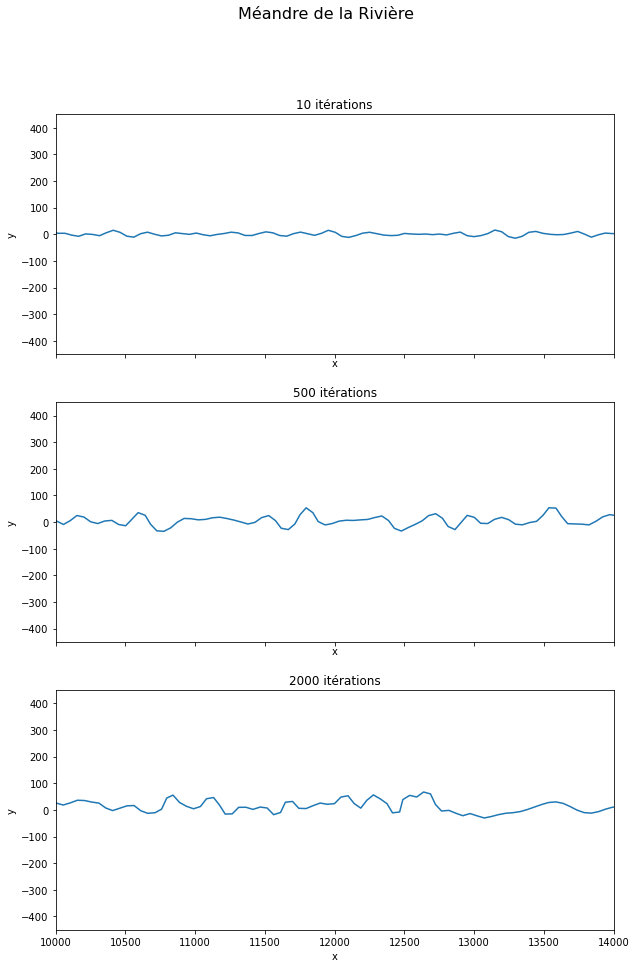

In [19]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, sharex=True, figsize=(10, 15))
ax1.plot(centerlines[0][0], centerlines[0][1])
ax1.set_ylim(-450, 450)
ax1.set_xlim(10000, 14000)
ax1.set_title('10 itérations')  
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.plot(centerlines[50][0], centerlines[50][1])
ax2.set_ylim(-450, 450)
ax2.set_xlim(10000, 14000)
ax2.set_title('500 itérations')  
ax2.set_xlabel('x')
ax2.set_ylabel('y')


ax3.plot(centerlines[198][0], centerlines[198][1])
ax3.set_ylim(-450, 450)
ax3.set_xlim(10000, 14000)
ax3.set_title('2000 itérations')  
ax3.set_xlabel('x')
ax3.set_ylabel('y')

plt.suptitle('Méandre de la Rivière', fontsize=16)  
plt.savefig('Meandre_de_la_Riviere_Modele2_reference')
plt.show()

### Taux de migration moyen

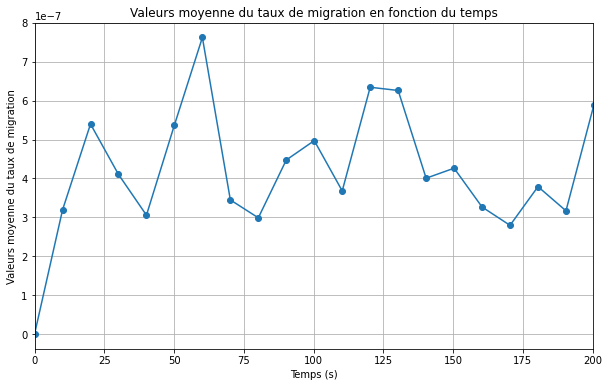

In [20]:
R1_abs = np.abs(R1)
window = 10
R1_abs_moyen = [np.mean(R1_abs[i:i+window]) for i in range(0, len(R1), window)]
temps_10 = np.linspace(0,len(R1_abs),len(R1_abs_moyen))
plt.figure(figsize=(10, 6))
plt.plot(temps_10, R1_abs_moyen, marker='o')
plt.xlabel('Temps (s)')
plt.ylabel('Valeurs moyenne du taux de migration')
plt.title('Valeurs moyenne du taux de migration en fonction du temps')
plt.xlim(0,200)
plt.grid(True)
plt.savefig('Valeurs_moyenne_taux_de_migration_Modele2_reference')
plt.show()